<a href="https://colab.research.google.com/github/josepablortiz/Aguacate/blob/main/Test_JP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Narrative Wave Test
José Pablo Ortiz

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import  more_itertools#Rolling Window Generator
from matplotlib import animation

# Introduction

There is a submersible hydraulic pump, and it is of interest in analyzing the behavior of this device. Specially, it is of interest to monitor when the hydraulic pump is failing. Statistical Process Control(SPC) is a series of method employed to monitor and control the quality of a process. A no parametric statistical process control method is used to analyze the behavior of the pump failure data.

First, a brief introudction of the key concepts of statistical control process is presented. Then an empirical analysis and a SPC modelation of the pump failure data is gonna be made. To end this test, a proposed algorithm to monitor the pump failure data is gonna be made.


# Statistical Control Process


Statistical Process Control(SPC) is a series of techniques used to monitor and control the quality of a process. A process is $\textbf{In Control}$(IC) when it satisfies the quality characteristics set by the experimenter and the sources of variation are common causes. The process is $\textbf{Out of Control}$(OC) when the quality of the process is defective and the sources of variation are special causes. In a few words, a process presents $\textbf{common causes}$ of variation when the noise is stable and inherent within the system[Wiki]. The $\textbf{special causes}$ of variation occurs when the noise of the process is outside the historical experience base and it is significantly higher than the common causes of variation[Wiki]. Thus, the task of SPC can be summarized as identifying when a special cause of variation has occurred that has driven the process to an OC status. 



## Brief techniqual details


###Control Chart

A control chart is a run chart with 3 control limits: **central line**(CL), **upper control limit**(UCL) and **lower control limit**(LCL). The values of observed values of a **charting statistic** are plotted on the control chart. Then, the control limits aid the user to define rules and to decide whether a process is IC or OC.[Chak] 


Let $\left(X_t\right)_{t=1}^{nm}$ be a sample of the process of intereset, the way data is going to be handeled during this test is through $m$ rolling window of size $n$ and stride $n$ from $\left(X_t\right)_{t=1}^{nm}$. That,
$$\left\{(X_t)_{t=1}^{n},(X_t)_{t=n}^{2n},\dots,(X_t)_{t=(m-1)n}^{mn}\right\}.$$

This is done because each charting statistic, $T_i$, is calculated as $$T_i = T(X_{(i-1)n++1},\dots,X_{(i-1)n+m}),$$ 
where $T:\mathbb{R}^{n}\rightarrow \mathbb{R}$ is the charting statistic function

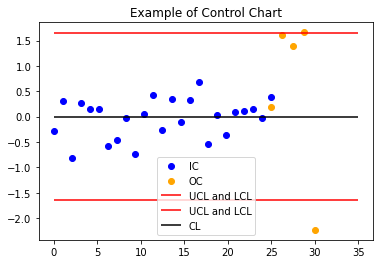

In [ ]:
n = 6
m = 30

#Chartin Statistic: mean
np.random.seed(133)
dataIC = np.mean(np.random.normal(scale = 1,size = [m-5,n]),axis = 1)

np.random.seed(12)
dataOC = np.mean(np.random.normal(scale = 2,loc = 1,size = [5,n]),axis = 1)

xIC = np.linspace(0,m-5,m-5)
xOC = np.linspace(m-5,m,5)
z_value = st.norm.ppf(0.95,scale = 1) 

plt.scatter(x=xIC,y = dataIC,label = 'IC',color = 'blue')
plt.scatter(x = xOC,y =dataOC,label='OC',color = 'orange')
plt.hlines(y =z_value,xmin = 0,xmax=35,color = 'red',label = 'UCL and LCL')
plt.hlines(y =-z_value,xmin = 0,xmax=35 ,color = 'red',label = 'UCL and LCL')
plt.hlines(y =0,xmin = 0,xmax=35 ,color = 'black',label = 'CL')
plt.title('Example of Control Chart')
plt.legend()
plt.show()

### Hypothesis testing


The mathematical/statistical way of fundamenting this technique is through sequential hypothesis testing. The experimenter needs to establish when the process is IC and OC, i.e., the process is OC if the variance is to high or if there has been a mean shift. Then, the following test is performed

\begin{equation}
H_0:\text{process is IC}\quad\text{vs.}\quad H_1:\text{process is OC}.
\end{equation}

How the data behaves will dictate wheter to perform a parametric or non-parametric test. Getting ahead on the narrative, the SPC technique will be employed  is based on a non-parametric test.

# Modeling the pump failures using SPC

In [ ]:
df = pd.read_csv('PumpFailure.csv',index_col=0)
df.index = pd.to_datetime(df.index)
#Data had some duplicated observations with similar value,
#no problem in keeping the first ones.
df = df[~df.index.duplicated(keep='first')]

In [ ]:
from IPython.display import Image
Image(open('pump.gif','rb').read())

## Empirical observations of the pump

Let $(X_t)_{t\geq 1}$ be the hydraulic pump process. The animation shown up is the process $(X_t)_{t\geq 1}$. After a visual analysis of the animation the following statements can be made about the behavior of $(X_t)_{t\geq 1}$:

1. There are 2 special causes of variation: a fail and a fix. A fail will drive the pump of the series to a lower level and a fix to a higher.
2. If the process has a mean larger than 65 it **may** satisfy the quality requirements.
2.   When the process is IC both the mean and variance of the pump are relatively stable.
3.   When a failure occurs the pump decreases gradually, it will decrease until a fix is made, and the variance of the series grows. 
4.   After a fix has been made the pump increases and the variance is larger than in the IC status.
5.   A fix can be defective in the sense that there are pump increments, but the process never achieves an IC status.
6.   If the fix is not defective the new location of the IC run will not necessarily be the same location as the in the last IC run.
7.   After a big increase of the pump, caused by a fix, there will big drop of the pump. This is due to the OC status of the process after a fix 

## First Difference

The fact that the mean/location of the process can vary between IC runs of the process, eliminates the idea to test the process for a mean/location shift. A test for a variance change might sound plausible, but again it seems that the value of the variance might change from different IC runs. Although, there   


Let's consider the first difference process
\begin{equation}
  Y_t = X_{t+1}-X_{t}.
\end{equation}

If the pump process it is expected that the IC mean/location of $(Y_t)$ will be 0. More so, if a failure(fix) has occurred and the mean/location of $Y_t$ is gonna be negative(positive). Although after a failure(fix) the exact location of $(Y_t)$ is not known, it can be set by the experimenter in a trial an error way.

Perhaps the biggest danger in monitoring the $(Y_t)$ process is that the monitoring task will not take into account the location of $(X_t)$. We accept this risk, because in practice when the location of $(X_t)$ is low then the person in charge of monitoring the process should notice that notice.

Thus, a location test of $(Y_t)$ is gonna be the base for the monitoring task of $(X_t)$.



## Parametric vs No Parametric





In [ ]:
from IPython.display import Image
Image(open('vardif.gif','rb').read())

A no parametric location test will be used the for the following reasons:



1.   In a parametric test the variance of the IC process needs to be estimated. It's not clear whether the variance of $(Y_t)$ is the same for different run of IC.
2.   In the context of SPC usually it's assumed that the data follows a normal distribution. For a given $n$, the size of the rolling window, the animation above shows that although the data is symmetric, it doesn't follows the normal distribution.
3.   The assumptions of a No Parametric test are far less restricting than in the parametric case. Usually the only assumptions is symmetry, which $(Y_t)$ follows.


## Wilcoxn Signed Rank test




'The one-sample Wilcoxon signed-rank test it is used to test whether data comes from a symmetric population with a specified location.'[Conover] A two sided Wilcoxn signed-rank test has the following hypothesis:
\begin{equation}
  H_0: \mu = \mu_0 = 0 \quad\text{vs.}\quad H_1: \mu\leq \mu_0 = 0.
\end{equation}

Without going into details the statistic used in the Wilcoxon signed-rank is 
\begin{equation}
SR=\sum _{s=1}^{n} = \mbox{sign}(X_{s}-\mu_0)R_{s},
\end{equation}
where $R_{s}$ is 'the rank of the absolute deviation of $|X_s-\mu_0|$ among $\left\{|X_1-\mu_0|,\dots,|X_n-\mu_0|\right\}$.'[chak] The null hypothesis will be rejected if $|SR|>a$, for some positive $a$.

A one sided test can be devised in a similar way as the two sided. 


## Exponentially Weighted Moving Average based on the Wilcoxn signed rank test


'The Exponentially Weighted Moving Average (EWMA) is a statistic for monitoring the process that averages the data in a way that gives less and less weight to data as they are further removed in time.'[NIST] This last reason makes the EWMA SPC technique useful for the task of monitoring the $(Y_t)$ process.

In order to calculate the charting statistic, from an EWMA based on a two sided Wilcoxn Signed Rank test, first the Wilcoxn statistic from a rolling window of size $n$ is calculated

\begin{equation}
SR_t = \sum_{s = 1}^{n}\mbox{sign}(Y_{ts}-\mu_0)R_{ts}.
\end{equation}
Then the charting statistic, $Z_t$, is calculated through the following recursion:
\begin{equation}
Z_t = \lambda SR_t+ (1-\lambda)Z_{t-1}
\end{equation}
with $Z_0 = 0$ and '$\lambda$ is a constant that determines the depth of memory of the EWMA'[NIST], and it is set by the experimenter.

## IC process to OC

When $Y_t$ is IC it is gonna be established that the process has an OC when there has been a down shift. Thus, the test hypothesis is a one sided test

\begin{equation}
  H_0: \mu = \mu_0 = 0 \quad\text{vs.}\quad H_1: \mu\leq \mu_0 = 0,
\end{equation}
if we reject $H_0$ there is evidence that the process is OC. Given that this is a one sided test the charting statistic will be given by

\begin{equation}
Z^{+}_t = \max(0,\lambda SR_t+ (1-\lambda)Z_{t-1}),
\end{equation}
and the process will enter an OC status if 

\begin{equation}
Z^{+}_t < -L\sigma_{SR_t}\sqrt{\frac{\lambda}{2-\lambda}\left(1-(1-\lambda\right)^{2t})}=LCL,
\end{equation}
where $L$ is set by the experimenter and $\sigma_{SR_t}=\sqrt{\frac{n(n+1)(2n+1)}{6}}$ is the variance of the $SR_t$ statistic.[Chak]


In [ ]:
def rank(X,mu):
  aux = np.abs(np.asarray(X)-mu)
  ranks = np.argsort(np.argsort(aux))
  return ranks+1


In [ ]:
def EWMASingRankIC(rw_dif,n):
  Z = [0]
  lam = 0.3
  t = 0
  tt = 1
  var = np.sqrt((n*(n+1)*(2*n+1))/6)
  L = 1
  for x in rw_dif[0:-1]:
    sign = np.sign(x)
    rank_aux = rank(x,0)
    Z.append(np.min([0,lam*np.sum(sign*rank_aux)+(1-lam)*Z[-1]]))
    LCL = -L*var*np.sqrt((lam/(2-lam))*(1-(1-lam)**(2*tt)))
    tt = tt+1
    if Z[-1]<LCL:
      t = t+n
      break
    t = t+n
  return t


## OC process to IC

When $X_t$ is OC there are big decrements and increments of the pump. The reason why there are decrements is because a failure has ocurred. On the other hand, increments occurs because of a fix. As stated before a fix can be defective and after a fix there might be big decrements; i.e., when $X_t$ has been fixed it presents a lot of variance.

Thus OC process can have two status: fail and fix. When a process is OC-fail status the hypothesis test that is gonna be performed is 

\begin{equation}
  H_0: \mu = \mu_0 \quad\text{vs.}\quad H_1: \mu\geq -\mu_0,
\end{equation}
for some $\mu_0<0$ and the charting statistic is
\begin{equation}
Z^{-}_t = \max(0,\lambda SR_t+ (1-\lambda)Z_{t-1}),
\end{equation}
and the process will leave the OC-fail status if 
\begin{equation}
Z^{-}_t >L\sigma_{SR_t}\sqrt{\frac{\lambda}{2-\lambda}\left(1-(1-\lambda\right)^{2t})}>UCL.
\end{equation}

The OC-fix test is similar to the IC test, but with $\mu_0>0$.[Chak]


In [ ]:
def EWMASingRankFailOC(rw_dif,n):
  Z = [0]
  lam = 0.3
  t = 0
  tt = 1
  var = np.sqrt((n*(n+1)*(2*n+1))/6)
  L = 1
  for x in rw_dif[0:-1]:
    sign = np.sign(x)
    rank_aux = rank(x,-0.2)
    Z.append(np.max([0,lam*np.sum(sign*rank_aux)+(1-lam)*Z[-1]]))
    UCL = L*var*np.sqrt((lam/(2-lam))*(1-(1-lam)**(2*tt)))
    tt = tt+1
    if Z[-1]>UCL:
      t = t+n
      break
    t = t+n
  return t

In [ ]:
def EWMASingRankFixOC(rw_dif,n):
  Z = [0]
  lam = 0.3
  t = 0
  tt = 1
  var = np.sqrt((n*(n+1)*(2*n+1))/6)
  L = 1
  for x in rw_dif[0:-1]:
    sign = np.sign(x)
    rank_aux = rank(x,0.2)
    Z.append(np.min([0,lam*np.sum(sign*rank_aux)+(1-lam)*Z[-1]]))
    LCL = -L*var*np.sqrt((lam/(2-lam))*(1-(1-lam)**(2*tt)))
    tt = tt+1
    if Z[-1]<LCL:
      t = t+n
      break
    t = t+n
  return t

# SPC algorithm  to monitor the pump

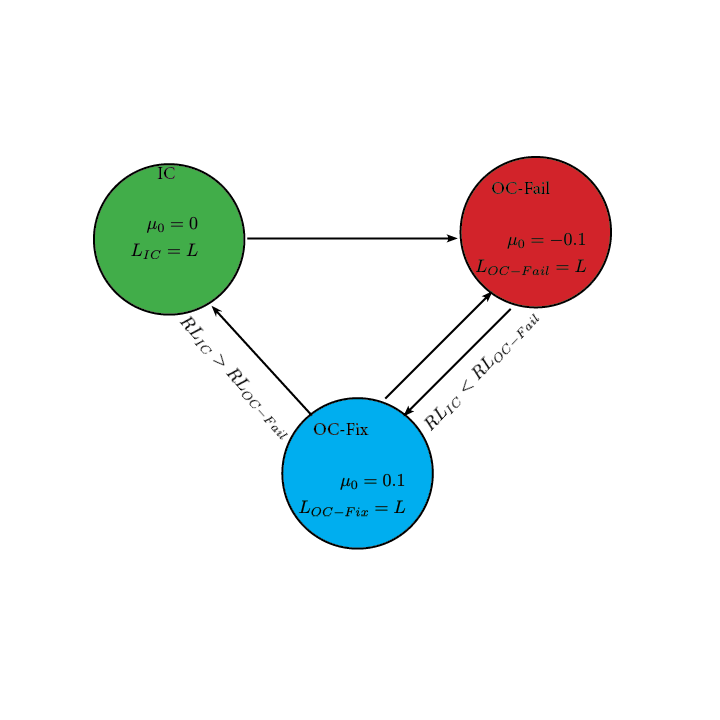

In [ ]:
from IPython.display import Image
Image(open('SPC_alg.png','rb').read())


The images above shows how the algorithm determines the status of the process. It was constructed in a logical way. Let's say that the process begins in an OC-Fix status, as in the pump data, then after changing to another given the nature of OC status it can happen that the fix was defective or that a lot 


*   IC: The only way of gettin out the IC status is if there's been a location shift to a lower level. That shift meant that a failure has happen. Therefore, to process moves to OC-Fail status.
*   OC-Fail: The new location of the $Y_t$ is negative, the parameter $\mu_0$ was set to $-0.1$ in an empirical way, it will change to positive only if there's been a Fix
*   OC-Fix: This is the most troublesome status. After a fix the variance of the process is unstable, the fix can be defective and it is almost always followed by a big decrements. Thus, when the process leaves the OC-Fix status it will move to the status with the largest run length. 

The **run length**, $RL$, is the time the process stays in a status before changing to another one. The run length depends on the size of the test, in fact it's proportional to the inverse of the size. Thus, in order to be able to  compare the run length of IC run and OC-Fail, it is needed that those tests have the same size. Given the no parametric approach of the problem the size of the test is not known.  Nevertheless, by setting the parameters $\lambda$ and $L$ equal across the IC and OC-Fail status will ensure that size of the test is equal in both status, which in turn implies that the status with the largest run length has a better fit on the data.

In [ ]:
df = pd.read_csv('PumpFailure.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df = df[~df.index.duplicated(keep='first')]

nm = len(df)
t_list = [0]
n = 20
df['status'] = np.nan


rw_dif = list(more_itertools.windowed(df['value'].diff(1),n,step= n))
rw =  list(more_itertools.windowed(df['value'],n,step= n))
t1 = EWMASingRankFixOC(rw_dif[1:],n)
t_list.append(t1)
process = 'OCFix'
df['status'][np.sum(t_list[0:-1]):np.sum(t_list)] = process


while np.sum(t_list)<nm-2*n:
    rw_dif = list(more_itertools.windowed(df['value'][np.sum(t_list)-n:].diff(1),n,step= n))[1:]
    if process == 'In Control':
      t_aux = EWMASingRankFailOC(rw_dif,n)
      process = 'OCFail'
      t_list.append(t_aux)
    elif process == 'OCFail':
      t_aux = EWMASingRankFixOC(rw_dif,n)
      process = 'OCFix'
      t_list.append(t_aux)
    else:
      t_aux1 = EWMASingRankIC(rw_dif,n)
      t_aux2 = EWMASingRankFailOC(rw_dif,n)
      t_aux = np.max(np.asarray([t_aux1,t_aux2]))
      if t_aux1 == t_aux2:
        process = 'In Control'
      else:
        if t_aux==t_aux1:
          process = 'In Control'
        else:
          process = 'OCFail'
      t_list.append(t_aux)
    df['status'][np.sum(t_list[0:-1]):np.sum(t_list)] = process

In [ ]:
color = {'OCFix':'blue','In Control': 'green','OCFail':'red'}
df = df.replace({"status": color})

interval_len = 3000
init = 2323
x = np.linspace(init,init+interval_len,interval_len)
plt.scatter(x = x,y= df['value'][init:init+interval_len],color = df['status'][init:init+interval_len])
plt.show()

In [ ]:
from IPython.display import Image
Image(open('spc.gif','rb').read())

# Conclusions

1.   Forecasting Failures: This method is useful in preventing  catastrophic failures. The reason being that, in some cases, before a catastrophic fail there is a fail. If this fail is not fixed it will led to a catastrophic fail. 
2.   Speed: This method is quite fast.
3.   The method is very sensitive to $n$, the rolling window size.
4.   More can be done. Estimation through simulation of the run length and False Alarme Rate(type 1 error) of the IC and OC processes. This former could  be of help in the task of forecasting failures. 


# References

[Chak] Chakraborti, S., & Graham, M. (2019). Nonparametric Statistical Process Control (1st ed.). Wiley.

[Con] Conover, W. J. (1971). Practical nonparametric statistics (First Edition). Wiley.

[NIST] NIST/SEMATECH e-Handbook of Statistical Methods, http://www.itl.nist.gov/div898/handbook/, Retrieved June 4, 2022.

[Wiki] Wikipedia contributors. (2022, February 18). Common cause and special cause (statistics). Wikipedia. Retrieved June 4, 2022.